In [1]:
import sys
sys.path.append('/home/tcalo3/projects/project6')
sys.path.append('/home/tcalo3/projects/project6/src/modules/components/ganspace')

In [2]:
# Load model
from IPython.utils import io
import ipywidgets as widgets
from PIL import Image
import imageio
from models import get_instrumented_model
from decomposition import get_or_compute
from config import Config
from skimage import img_as_ubyte
from PIL import Image
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
import warnings
import numpy as np
import math
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood

warnings.filterwarnings('ignore')

# Speed up computation
torch.autograd.set_grad_enabled(False)
torch.backends.cudnn.benchmark = True

# Specify model to use
config = Config(
  model='StyleGAN',
  layer='g_mapping.dense7',
  output_class='ffhq',
  components=32,
  use_w=True,
  batch_size=5_000, # style layer quite small
)

inst = get_instrumented_model(config.model, config.output_class,
                              config.layer, torch.device('cuda'), use_w=config.use_w)

path_to_components = get_or_compute(config, inst)

model = inst.model

StyleGAN2: Optimized CUDA op FusedLeakyReLU not available, using native PyTorch fallback.
StyleGAN2: Optimized CUDA op UpFirDn2d not available, using native PyTorch fallback.


In [65]:
from src.modules.metrics.models.facenet import FaceNetModel

def sample_pca_space(n_samples, pca_components, pca_stdevs):
    random_samples = np.random.randn(n_samples, pca_components) * pca_stdevs
    return random_samples

def reconstruct_from_pca(pca_samples, pca_components, data_mean):
    original_data = np.dot(pca_samples, pca_components) + data_mean
    return original_data


def project_to_pca(new_data, pca_components, data_mean):
    centered_data = new_data - data_mean
    pca_projection = np.dot(centered_data, pca_components.T)
    return pca_projection

with torch.set_grad_enabled(False):
    facenet = FaceNetModel().eval()
    pass




In [101]:
# Utility function to manage hooks
def register_hooks(eval_model):
    features = {}
    layers = {
    'conv2d_2b': eval_model.resnet.conv2d_2b,
    'repeat_1_block0': eval_model.resnet.repeat_1[0],
    'mixed_6a': eval_model.resnet.mixed_6a,
    'conv2d_4a': eval_model.resnet.conv2d_4a,
    'conv2d_4b': eval_model.resnet.conv2d_4b,
    'repeat_2_block0': eval_model.resnet.repeat_2[0],
    'repeat_3_block0': eval_model.resnet.repeat_3[0],
    'mixed_7a': eval_model.resnet.mixed_7a,
    'block8': eval_model.resnet.block8,
    'last_linear': eval_model.resnet.last_linear
}

# Example usage, accessing the first block of the repeat_1 layers:

    
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.flatten(start_dim=1)
        return hook

    hooks = []
    for name, layer in layers.items():
        hook = layer.register_forward_hook(get_features(name))
        hooks.append(hook)
    return features, hooks

def clear_hooks(hooks):
    for hook in hooks:
        hook.remove()

In [99]:
def reconstruct_and_evaluate(x, target, model, latent_dirs,eval_model, data_mean):
    target_out = model.sample_np(target)
    target_image = Image.fromarray((target_out * 255).astype(np.uint8))
    target_resized_image = target_image.resize((160, 160), Image.NEAREST)
    target_tensor = torch.from_numpy(np.array(target_resized_image)).unsqueeze(0).permute(0, 3, 1, 2).float()

    x_reconstructed = reconstruct_from_pca(x,latent_dirs,data_mean)
    x_gan = model.sample_np(x_reconstructed.astype(np.float32))
    x_image = Image.fromarray((x_gan * 255).astype(np.uint8))
    x_resized_image = x_image.resize((160, 160), Image.NEAREST)
    x_tensor = torch.from_numpy(np.array(x_resized_image)).unsqueeze(0).permute(0, 3, 1, 2).float()
    

    features, hooks = register_hooks(eval_model)

    try:
        _ = eval_model(target_tensor)  # Process target image
        target_features = [features[layer] for layer in features.keys()]
        target_features_concat = torch.cat(target_features, dim=1)

        features.clear()  # Clear features for next input
        _ = eval_model(x_tensor)  # Process input image
        input_features = [features[layer] for layer in features.keys()]
        input_features_concat = torch.cat(input_features, dim=1)

    finally:
        clear_hooks(hooks) 
    similarity = torch.nn.functional.cosine_similarity(target_features_concat, input_features_concat, dim=1)


    return similarity

In [83]:
#@title Load a component at random
path_to_components="/home/tcalo3/projects/project6/src/modules/components/ganspace/cache/components/stylegan-ffhq_g_mapping.dense7_pca-full_c16_n300000_w.npz"
comps = np.load(path_to_components)

latent_dirs = comps['lat_comp'][:,0,:]
latent_stdevs = comps['lat_stdev']
data_mean = comps['lat_mean']

#load one at random
dims = latent_stdevs.shape[0]
num = np.random.randint(dims)
random_dir = latent_dirs[num]
random_dir_stdev = latent_stdevs[num]
print(f'Loaded Component No. {num}')

# Define the bounds of your optimization based on PCA variances (assuming normality and using some scale factor)
bounds = torch.stack([
    torch.tensor([-1 * stdev for stdev in latent_stdevs]),  # Lower bounds
    torch.tensor([1 * stdev for stdev in latent_stdevs])   # Upper bounds
]).double()




Loaded Component No. 9


In [84]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

def pull_arm(dimension, train_x, train_y, target, best_similarity, bounds):

    current_values = train_x[-1].clone()  

        # Create fixed bounds where only the selected dimension can vary
    lower_bounds, upper_bounds = bounds[0, :], bounds[1, :]
    fixed_bounds = torch.stack([lower_bounds, upper_bounds], dim=-1)

    # Set all other dimensions to their last observed value
    for i in range(fixed_bounds.shape[0]):
        if i != dimension:
            fixed_bounds[i] = torch.tensor([current_values[i], current_values[i]])

    with torch.enable_grad():
        gp_model = SingleTaskGP(train_x, train_y)
        mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
        fit_gpytorch_model(mll)
            
        EI = ExpectedImprovement(model=gp_model, best_f=train_y.max())
        # Optimize using the acquisition function
        candidate, _ = optimize_acqf(
            acq_function=EI,
            bounds=fixed_bounds.T,
            q=1,
            num_restarts=10,
            raw_samples=512,
        )

    candidate_similarity = reconstruct_and_evaluate(candidate, target, model, latent_dirs, facenet, data_mean)
    reward = 1 if candidate_similarity > best_similarity else 0
    best_similarity = candidate_similarity if candidate_similarity > best_similarity else best_similarity
    new_reward = torch.tensor([reward]).unsqueeze(-1).double()
    new_train_x = torch.cat([train_x, candidate], dim=0)
    new_train_y = torch.cat([train_y, new_reward], dim=0)

    return new_train_x, new_train_y, reward, best_similarity



In [102]:
num_arms = dims
max_steps = 1000
c = 1.5

# Initialize variables
Q_a = np.zeros(num_arms)
N_a = np.zeros(num_arms)
total_rewards = np.zeros(num_arms)

q_a = np.array([np.random.normal(0, 1) for _ in range(num_arms)])

# Function to select action using the Upper Confidence Bound algorithm
def select_action(t):
    with np.errstate(divide='ignore', invalid='ignore'):
        upper_confidence_bounds = Q_a + c * np.sqrt(np.log(t) / N_a)
    return np.argmax(upper_confidence_bounds)


target = model.sample_latent(1).cpu().detach().numpy() 
x_0 = sample_pca_space(1,dims,latent_stdevs)
best_similarity = reconstruct_and_evaluate(x_0, target, model, latent_dirs, facenet, data_mean)

train_x = sample_pca_space(1,dims,latent_stdevs)
similarity = reconstruct_and_evaluate(train_x, target, model, latent_dirs, facenet, data_mean)
reward = 1 if similarity > best_similarity else 0
action = select_action(0)

# Create a GP model from the existing data
train_x = torch.from_numpy(train_x).double()
train_y = torch.tensor([reward]).unsqueeze(-1).double()

# Running the bandit algorithm
for step in range(1, max_steps):
    action = select_action(step)
    train_x, train_y, reward, best_similarity = pull_arm(action, train_x, train_y, target, best_similarity, bounds)
    total_rewards[action] += reward
    N_a[action] += 1
    Q_a[action] += (reward - Q_a[action]) / N_a[action]
    print(step, action,best_similarity)
    

1 0 tensor([0.7421])
2 1 tensor([0.7421])
3 2 tensor([0.7421])
4 3 tensor([0.7421])
5 4 tensor([0.7421])
6 5 tensor([0.7421])
7 6 tensor([0.7421])
8 7 tensor([0.7421])
9 8 tensor([0.7421])
10 9 tensor([0.7421])
11 10 tensor([0.7421])
12 11 tensor([0.7421])
13 12 tensor([0.7421])
14 13 tensor([0.7421])
15 14 tensor([0.7421])
16 15 tensor([0.7421])
17 0 tensor([0.7421])
18 1 tensor([0.7421])
19 2 tensor([0.7421])
20 3 tensor([0.7421])
21 4 tensor([0.7421])
22 5 tensor([0.7421])
23 6 tensor([0.7618])
24 7 tensor([0.7623])
25 8 tensor([0.7629])
26 9 tensor([0.7629])
27 10 tensor([0.7679])
28 11 tensor([0.7679])
29 12 tensor([0.7679])
30 13 tensor([0.7679])
31 14 tensor([0.7679])
32 15 tensor([0.7679])
33 6 tensor([0.7679])
34 7 tensor([0.7679])
35 8 tensor([0.7679])
36 10 tensor([0.7679])
37 0 tensor([0.7679])
38 1 tensor([0.7679])
39 2 tensor([0.7679])
40 3 tensor([0.7679])
41 4 tensor([0.7679])
42 5 tensor([0.7679])
43 9 tensor([0.7679])
44 11 tensor([0.7679])
45 12 tensor([0.7679])
46 1

KeyboardInterrupt: 

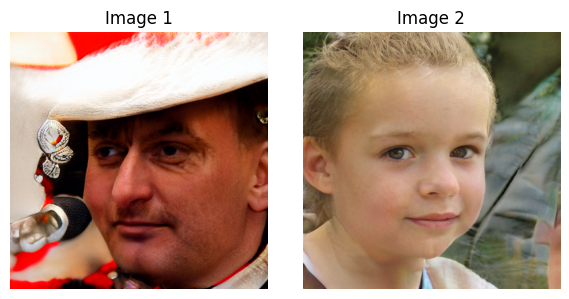

In [103]:
import matplotlib.pyplot as plt

# Generate the images
y_gan =  model.sample_np(target.astype(np.float32))
y_image = Image.fromarray((y_gan * 255).astype(np.uint8))
x_reconstructed = reconstruct_from_pca(train_x[-1],latent_dirs,data_mean)
x_gan = model.sample_np(x_reconstructed.astype(np.float32))
x_image = Image.fromarray((x_gan * 255).astype(np.uint8))

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Display the first image in the left subplot
ax1.imshow(y_image)
ax1.set_title('Image 1')
ax1.axis('off')

# Display the second image in the right subplot
ax2.imshow(x_image)
ax2.set_title('Image 2')
ax2.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [23]:
def get_tensors(x, target, model, latent_dirs, data_mean):
    target_out = model.sample_np(target)
    target_image = Image.fromarray((target_out * 255).astype(np.uint8))
    target_resized_image = target_image.resize((160, 160), Image.NEAREST)
    target_tensor = torch.from_numpy(np.array(target_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)

    x_reconstructed = reconstruct_from_pca(x,latent_dirs,data_mean)
    x_gan = model.sample_np(x_reconstructed.astype(np.float32))
    x_image = Image.fromarray((x_gan * 255).astype(np.uint8))
    x_resized_image = x_image.resize((160, 160), Image.NEAREST)
    x_tensor = torch.from_numpy(np.array(x_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)

    return x_tensor.float(),target_tensor.float()



